In [6]:
import os
import pandas as pd
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Embedding, LSTM
from tensorflow.keras.preprocessing.sequence import pad_sequences
import re
from sklearn.metrics import roc_auc_score, roc_curve
import matplotlib.pyplot as plt
from keras.optimizers import Adam
from bayes_opt import BayesianOptimization

In [7]:
%pip install bayesian-optimization

Note: you may need to restart the kernel to use updated packages.


In [12]:
class TweetClassificationModel:
    def __init__(self, data_file):
        # Load the dataset
        self.df = pd.read_csv(data_file)
        self.df = self.df.drop_duplicates('Tweet', keep='first')
        self.df['Tweet'].count()
        self.df["Cleaned_Tweet"] = [re.sub(r"(@[A-Za-z0-9_]+)|[^\w\s]|#|http\S+", "", v.lower()) for v in self.df["Tweet"]]
        self.df.drop('Tweet', axis=1, inplace=True)
        vals_to_replace = {'Relevant': 1, 'Not Relevant': 0}
        self.df['Category'] = self.df['Category'].map(vals_to_replace)
        self.df.dropna(inplace=True)
        self.df['Category'].unique()

        # Train-test split
        self.X_train, self.X_test, self.y_train, self.y_test = train_test_split(self.df['Cleaned_Tweet'], self.df['Category'], test_size=0.2, random_state=42)

        # Initialize Tokenizer
        self.tokenizer = Tokenizer()
        self.tokenizer.fit_on_texts(self.X_train)
        self.max_sequence_length = 100

    def preprocess_data(self):
        # Tokenize and pad the sequences
        X_train_sequences = self.tokenizer.texts_to_sequences(self.X_train)
        X_test_sequences = self.tokenizer.texts_to_sequences(self.X_test)
        self.X_train_padded = pad_sequences(X_train_sequences, maxlen=self.max_sequence_length)
        self.X_test_padded = pad_sequences(X_test_sequences, maxlen=self.max_sequence_length)

    def build_model(self,optimizer):
        # Build the LSTM model
        self.model = Sequential()
        self.model.add(Embedding(len(self.tokenizer.word_index) + 1, 32, input_length=self.max_sequence_length))
        self.model.add(LSTM(64, return_sequences=True))
        self.model.add(LSTM(64))
        self.model.add(Dense(1, activation='sigmoid'))
        self.model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])

    def train_model(self, epochs=5, batch_size=32):
        # Train the LSTM model
        history = self.model.fit(self.X_train_padded, self.y_train, validation_data=(self.X_test_padded, self.y_test), epochs=epochs, batch_size=batch_size)
        return history

    def evaluate_model(self):
        # Evaluate the model on the test set
        y_pred = self.model.predict(self.X_test_padded)
        auc = roc_auc_score(self.y_test, y_pred)
        print("AUC:", auc)
        return y_pred  # Return y_pred for later use in plot_roc_curve

    def plot_roc_curve(self, y_pred):
        # Plot the ROC curve
        auc = roc_auc_score(self.y_test, y_pred)
        fpr, tpr, thresholds = roc_curve(self.y_test, y_pred)
        plt.figure()
        plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % auc)
        plt.plot([0, 1], [0, 1], 'k--')
        plt.legend(loc="lower right")
        plt.show()
    def plot_learning_curves(self):
        # Plot the learning curves
        plt.figure()
        plt.plot(history.history['accuracy'], label='Training Accuracy')
        plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
        plt.xlabel('Epochs')
        plt.ylabel('Accuracy')
        plt.legend()
        plt.show()

        plt.figure()
        plt.plot(history.history['loss'], label='Training Loss')
        plt.plot(history.history['val_loss'], label='Validation Loss')
        plt.xlabel('Epochs')
        plt.ylabel('Loss')
        plt.legend()
        plt.show()
    def bayesian_optimization(self):
        # Define the hyperparameter search space
        pbounds = {
            'learning_rate': (1e-5, 1e-2),
            'dropout_rate': (0.1, 0.5),
            'lstm_units': (32, 128)
        }

        def evaluate_model(learning_rate, dropout_rate, lstm_units):
            # Build the model with the given hyperparameters
            optimizer = Adam(learning_rate=learning_rate)
            self.build_model(optimizer)
            # Train the model with the current hyperparameters
            history = self.train_model(epochs=5, batch_size=32)
            # Return the validation accuracy as the objective to maximize
            return history.history['val_accuracy'][-1]

        # Initialize Bayesian Optimization
        optimizer = BayesianOptimization(
            f=evaluate_model,
            pbounds=pbounds,
            verbose=2,  # Set verbose=2 to see the optimization process
            random_state=42
        )
        # Perform optimization
        optimizer.maximize(init_points=5, n_iter=10)

        # Get the best hyperparameters
        best_hyperparams = optimizer.max['params']
        print("Best Hyperparameters:")
        print(best_hyperparams)

        # Train the model with the best hyperparameters
        optimizer = Adam(learning_rate=best_hyperparams['learning_rate'])
        self.build_model(optimizer)
        history = self.train_model(epochs=50, batch_size=32)

        # Evaluate and plot ROC curve with the best model
        y_pred = self.evaluate_model()
        self.plot_roc_curve(y_pred)

        # Plot learning curves of the best model
        self.Overfitting_Underfitting(history)

USING ADAM OPTIMIZER

Epoch 1/5
254/254 [==============================] - 54s 162ms/step - loss: 0.5196 - accuracy: 0.7391 - val_loss: 0.4399 - val_accuracy: 0.8054
Epoch 2/5
254/254 [==============================] - 42s 166ms/step - loss: 0.3128 - accuracy: 0.8747 - val_loss: 0.4448 - val_accuracy: 0.8059
Epoch 3/5
254/254 [==============================] - 46s 182ms/step - loss: 0.1946 - accuracy: 0.9299 - val_loss: 0.5426 - val_accuracy: 0.7926
Epoch 4/5
254/254 [==============================] - 42s 166ms/step - loss: 0.1390 - accuracy: 0.9533 - val_loss: 0.6196 - val_accuracy: 0.7832
Epoch 5/5
64/64 [==============================] - 5s 43ms/step
AUC: 0.844260471938571


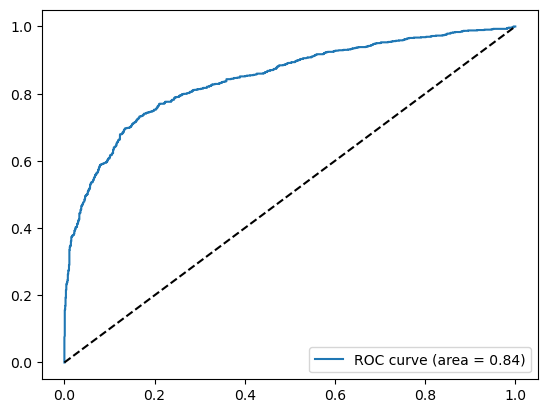

NameError: name 'history' is not defined

<Figure size 640x480 with 0 Axes>

In [13]:
if __name__ == "__main__":
    data_file = 'C:\\Users\\user\\Downloads\\Group3-news-text-sanitized.csv'
    opt = input('Enter your optimizer')
    model = TweetClassificationModel(data_file)
    model.preprocess_data()
    model.build_model(opt)
    model.train_model()
    y_pred = model.evaluate_model()
    model.plot_roc_curve(y_pred)
    model.plot_learning_curves()

USING rmsprop Optimizer

Epoch 1/5
254/254 [==============================] - 44s 148ms/step - loss: 0.5798 - accuracy: 0.6838 - val_loss: 0.4875 - val_accuracy: 0.7704
Epoch 2/5
254/254 [==============================] - 36s 143ms/step - loss: 0.4085 - accuracy: 0.8238 - val_loss: 0.4493 - val_accuracy: 0.7946
Epoch 3/5
254/254 [==============================] - 39s 154ms/step - loss: 0.3508 - accuracy: 0.8575 - val_loss: 0.5062 - val_accuracy: 0.7990
Epoch 4/5
254/254 [==============================] - 46s 182ms/step - loss: 0.3014 - accuracy: 0.8808 - val_loss: 0.4828 - val_accuracy: 0.7990
Epoch 5/5
64/64 [==============================] - 5s 50ms/step
AUC: 0.8604167334605088


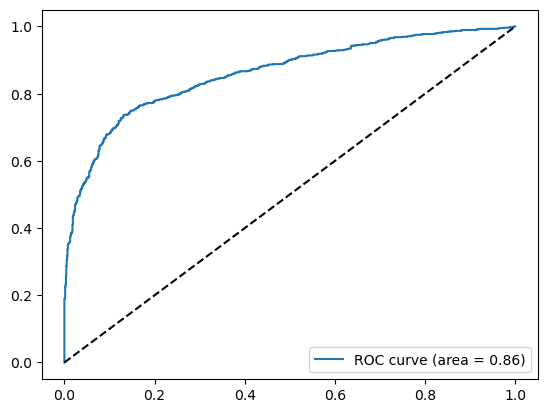

NameError: name 'history' is not defined

<Figure size 640x480 with 0 Axes>

In [6]:
if __name__ == "__main__":
    data_file = 'C:\\Users\\user\\Downloads\\Group3-news-text-sanitized.csv'
    opt = input('Enter your optimizer')
    model = TweetClassificationModel(data_file)
    model.preprocess_data()
    model.build_model(opt)
    model.train_model()
    y_pred = model.evaluate_model()
    model.plot_roc_curve(y_pred)
    model.plot_learning_curves()

USING SGD Optimizer

Epoch 1/5
254/254 [==============================] - 61s 201ms/step - loss: 0.6840 - accuracy: 0.5765 - val_loss: 0.6803 - val_accuracy: 0.5812
Epoch 2/5
254/254 [==============================] - 48s 188ms/step - loss: 0.6809 - accuracy: 0.5790 - val_loss: 0.6800 - val_accuracy: 0.5812
Epoch 3/5
254/254 [==============================] - 47s 184ms/step - loss: 0.6808 - accuracy: 0.5790 - val_loss: 0.6799 - val_accuracy: 0.5812
Epoch 4/5
254/254 [==============================] - 45s 177ms/step - loss: 0.6807 - accuracy: 0.5790 - val_loss: 0.6798 - val_accuracy: 0.5812
Epoch 5/5
64/64 [==============================] - 7s 65ms/step
AUC: 0.5327358290184512


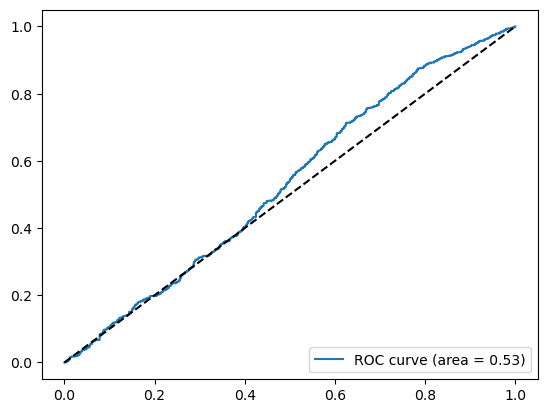

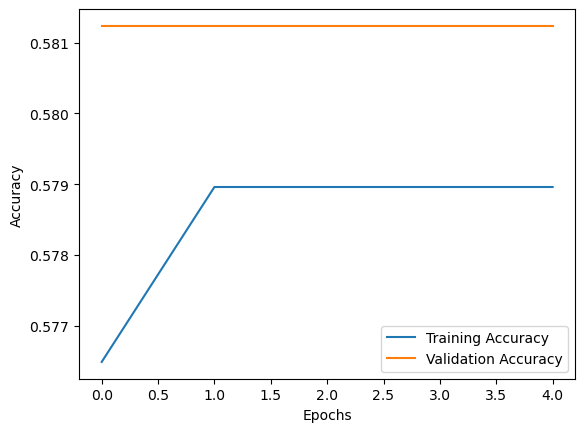

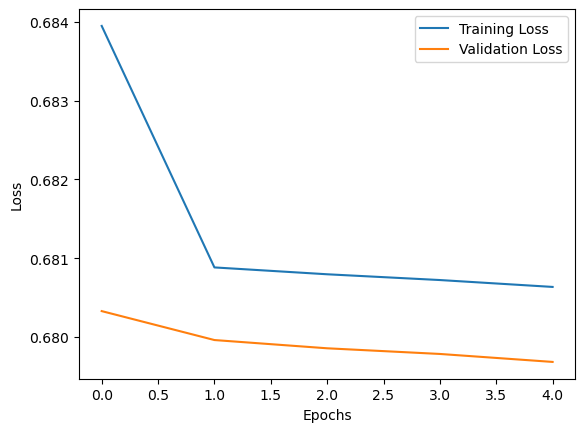

In [ ]:
if __name__ == "__main__":
    data_file = 'C:\\Users\\user\\Downloads\\Group3-news-text-sanitized.csv'
    opt = input('Enter your optimizer')
    model = TweetClassificationModel(data_file)
    model.preprocess_data()
    model.build_model(opt)
    model.train_model()
    y_pred = model.evaluate_model()
    model.plot_roc_curve(y_pred)
    model.plot_learning_curves()

Using AdaDelta Optimizer


Epoch 1/5
254/254 [==============================] - 58s 190ms/step - loss: 0.6928 - accuracy: 0.5525 - val_loss: 0.6926 - val_accuracy: 0.5714
Epoch 2/5
254/254 [==============================] - 47s 187ms/step - loss: 0.6925 - accuracy: 0.5749 - val_loss: 0.6922 - val_accuracy: 0.5773
Epoch 3/5
254/254 [==============================] - 57s 223ms/step - loss: 0.6921 - accuracy: 0.5788 - val_loss: 0.6919 - val_accuracy: 0.5812
Epoch 4/5
254/254 [==============================] - 44s 174ms/step - loss: 0.6918 - accuracy: 0.5790 - val_loss: 0.6916 - val_accuracy: 0.5812
Epoch 5/5
64/64 [==============================] - 7s 55ms/step
AUC: 0.5266627659062856


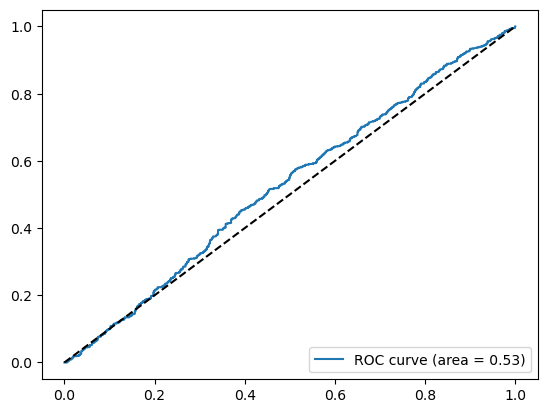

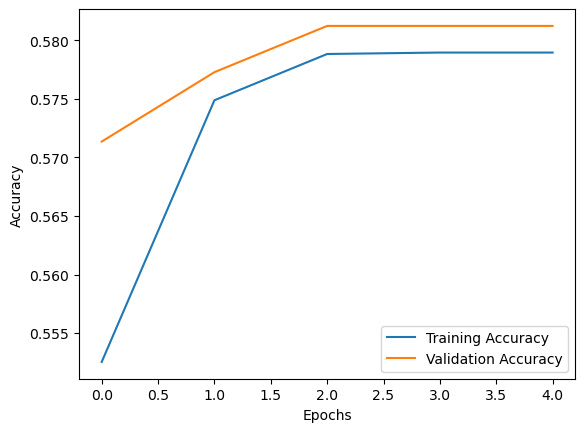

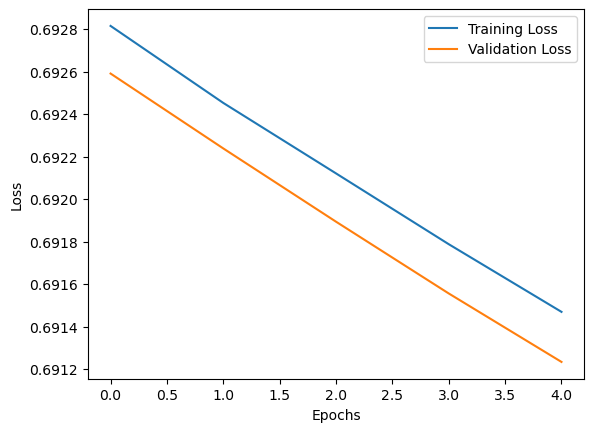

In [ ]:
if __name__ == "__main__":
    data_file = 'C:\\Users\\user\\Downloads\\Group3-news-text-sanitized.csv'
    opt = input('Enter your optimizer')
    model = TweetClassificationModel(data_file)
    model.preprocess_data()
    model.build_model(opt)
    model.train_model()
    y_pred = model.evaluate_model()
    model.plot_roc_curve(y_pred)
    model.plot_learning_curves()

Using Adamax

Epoch 1/5
254/254 [==============================] - 68s 231ms/step - loss: 0.6331 - accuracy: 0.6333 - val_loss: 0.5378 - val_accuracy: 0.7417
Epoch 2/5
254/254 [==============================] - 52s 205ms/step - loss: 0.4613 - accuracy: 0.7969 - val_loss: 0.5028 - val_accuracy: 0.7674
Epoch 3/5
254/254 [==============================] - 53s 211ms/step - loss: 0.3922 - accuracy: 0.8347 - val_loss: 0.4738 - val_accuracy: 0.7911
Epoch 4/5
254/254 [==============================] - 47s 185ms/step - loss: 0.3386 - accuracy: 0.8618 - val_loss: 0.4673 - val_accuracy: 0.7891
Epoch 5/5
64/64 [==============================] - 5s 63ms/step
AUC: 0.8565869415366858


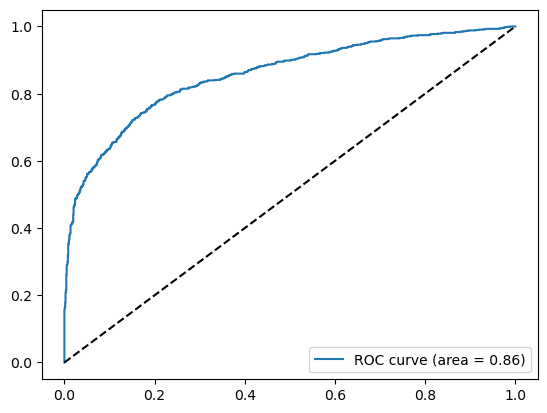

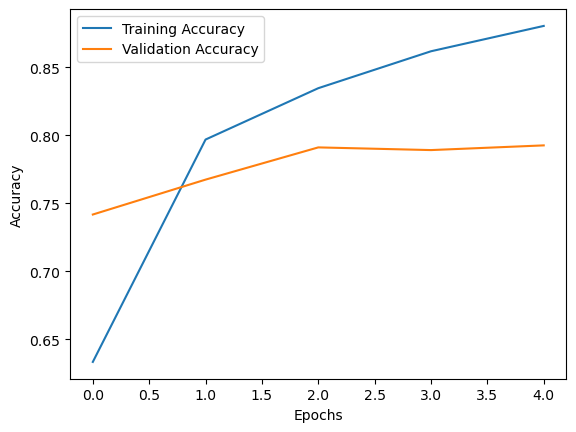

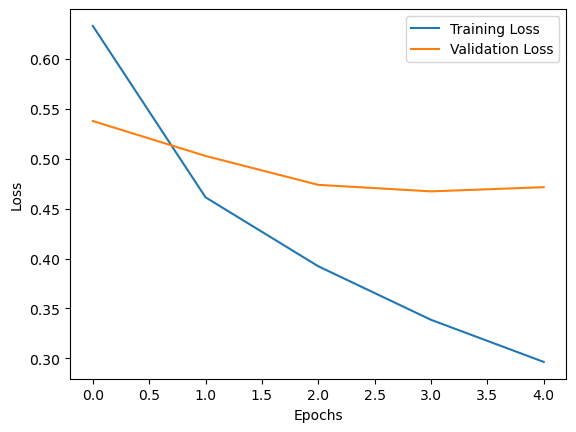

In [ ]:
if __name__ == "__main__":
    data_file = 'C:\\Users\\user\\Downloads\\Group3-news-text-sanitized.csv'
    opt = input('Enter your optimizer')
    print(opt)
    model = TweetClassificationModel(data_file)
    model.preprocess_data()
    model.build_model(opt)
    model.train_model()
    y_pred = model.evaluate_model()
    model.plot_roc_curve(y_pred)
    model.plot_learning_curves()

rmsprop
Epoch 1/5
254/254 [==============================] - 59s 197ms/step - loss: 0.5772 - accuracy: 0.6939 - val_loss: 0.4654 - val_accuracy: 0.7921
Epoch 2/5
254/254 [==============================] - 48s 190ms/step - loss: 0.4065 - accuracy: 0.8290 - val_loss: 0.4464 - val_accuracy: 0.8074
Epoch 3/5
254/254 [==============================] - 48s 188ms/step - loss: 0.3443 - accuracy: 0.8568 - val_loss: 0.4538 - val_accuracy: 0.8163
Epoch 4/5
254/254 [==============================] - 46s 181ms/step - loss: 0.3041 - accuracy: 0.8781 - val_loss: 0.4736 - val_accuracy: 0.8079
Epoch 5/5
64/64 [==============================] - 6s 70ms/step
AUC: 0.8607899440534778


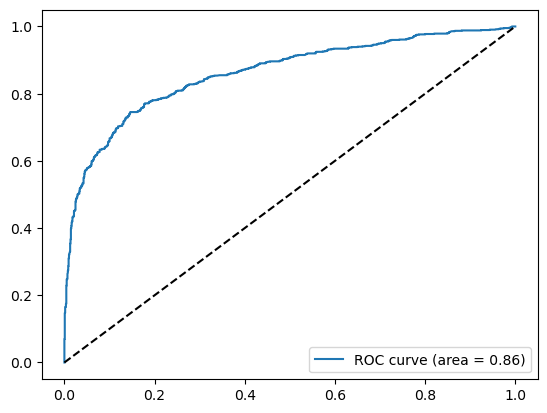

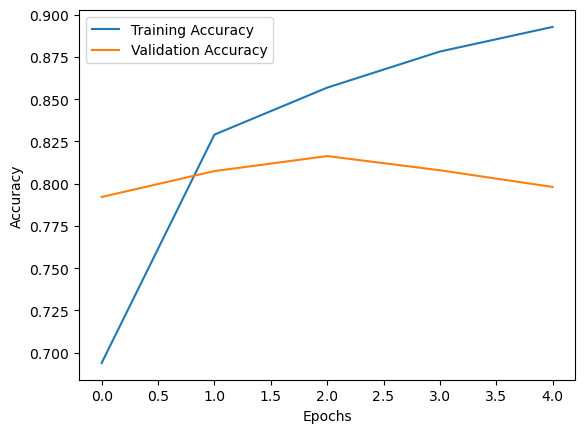

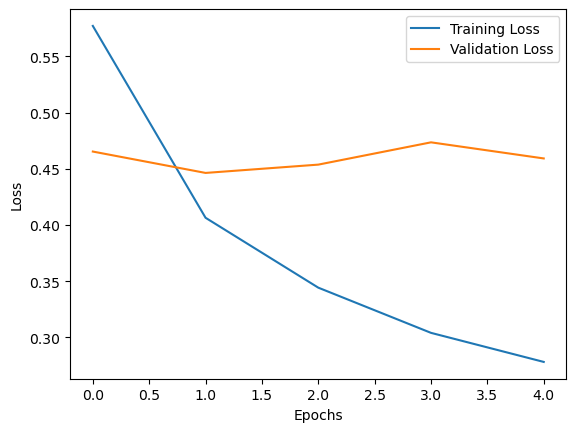

In [ ]:
if __name__ == "__main__":
    data_file = 'C:\\Users\\user\\Downloads\\Group3-news-text-sanitized.csv'
    opt = input('Enter your optimizer')
    print(opt)
    model = TweetClassificationModel(data_file)
    model.preprocess_data()
    model.build_model(opt)
    model.train_model()
    y_pred = model.evaluate_model()
    model.plot_roc_curve(y_pred)
    model.plot_learning_curves()

SGD and AdaDelta optimizers performed poorly with relatively low training and validation accuracy, and their AUC values were not significantly better than random guessing.

 RMSprop and AdaMax optimizers seem to have provided better outputs for this specific model and dataset, as they achieved higher validation accuracy and AUC compared to the other optimizers

|   iter    |  target   | dropou... | learni... | lstm_u... |
-------------------------------------------------------------
Epoch 1/5
254/254 [==============================] - 52s 168ms/step - loss: 0.5327 - accuracy: 0.7429 - val_loss: 0.4836 - val_accuracy: 0.7931
Epoch 2/5
254/254 [==============================] - 38s 151ms/step - loss: 0.3014 - accuracy: 0.8855 - val_loss: 0.5260 - val_accuracy: 0.7812
Epoch 3/5
254/254 [==============================] - 39s 153ms/step - loss: 0.1829 - accuracy: 0.9359 - val_loss: 0.6327 - val_accuracy: 0.7842
Epoch 4/5
254/254 [==============================] - 38s 150ms/step - loss: 0.1158 - accuracy: 0.9589 - val_loss: 0.6910 - val_accuracy: 0.7807
Epoch 5/5
254/254 [==============================] - 38s 149ms/step - loss: 0.0788 - accuracy: 0.9684 - val_loss: 0.8442 - val_accuracy: 0.7659
| 1         | 0.7659    | 0.2498    | 0.009508  | 102.3     |
Epoch 1/5
254/254 [==============================] - 52s 160ms/step - loss: 0.5139 - accuracy:

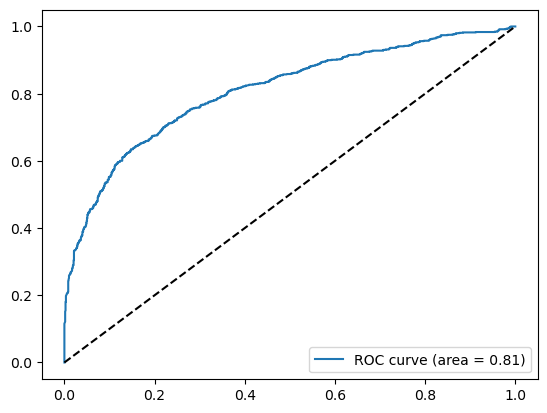

AttributeError: 'TweetClassificationModel' object has no attribute 'Overfitting_Underfitting'

In [14]:
data_file = 'C:\\Users\\user\\Downloads\\Group3-news-text-sanitized.csv'
model = TweetClassificationModel(data_file)
model.preprocess_data()
model.bayesian_optimization()

"hyperparameter tuning "